# Strategies for climatology calculations

This notebook is motivated by
[this post](https://discourse.pangeo.io/t/understanding-optimal-zarr-chunking-scheme-for-a-climatology/2335)
on the Pangeo discourse forum.


In [1]:
import dask.array
import flox
import flox.xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

Let's first create an example Xarray Dataset representing the OISST dataset,
with chunk sizes matching that in the post.


In [2]:
oisst = xr.DataArray(
    dask.array.ones((14532, 720, 1440), chunks=(20, -1, -1)),
    dims=("time", "lat", "lon"),
    coords={
        "time": pd.date_range("1981-09-01 12:00", "2021-06-14 12:00", freq="D")
    },
    name="sst",
)

## map-reduce

The default
[method="map-reduce"](https://flox.readthedocs.io/en/latest/implementation.html#method-map-reduce)
doesn't work so well. We aggregate all days in a single chunk.

For this to work well, we'd want smaller chunks in space and bigger chunks in
time.


In [3]:
flox.xarray.xarray_reduce(
    oisst,
    oisst.time.dt.dayofyear,
    func="mean",
    method="map-reduce",
)

<xarray.DataArray 'sst' (dayofyear: 366, lat: 720, lon: 1440)>
dask.array<transpose, shape=(366, 720, 1440), dtype=float64, chunksize=(366, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Dimensions without coordinates: lat, lon

## Rechunking for map-reduce

We can split each chunk along the `lat`, `lon` dimensions to make sure the
output chunk sizes are more reasonable


In [4]:
flox.xarray.xarray_reduce(
    oisst.chunk({"lat": -1, "lon": 120}),
    oisst.time.dt.dayofyear,
    func="mean",
    method="map-reduce",
)

<xarray.DataArray 'sst' (dayofyear: 366, lat: 720, lon: 1440)>
dask.array<transpose, shape=(366, 720, 1440), dtype=float64, chunksize=(366, 720, 120), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Dimensions without coordinates: lat, lon

But what if we didn't want to rechunk the dataset so drastically (note the 10x
increase in tasks). For that let's try `method="cohorts"`

## method=cohorts

We can take advantage of patterns in the groups here "day of year".
Specifically:

1. The groups at an approximately periodic interval, 365 or 366 days
2. The chunk size 20 is smaller than the period of 365 or 366. This means, that
   to construct the mean for days 1-20, we just need to use the chunks that
   contain days 1-20.

This strategy is implemented as
[method="cohorts"](https://flox.readthedocs.io/en/latest/implementation.html#method-cohorts)


In [5]:
flox.xarray.xarray_reduce(
    oisst,
    oisst.time.dt.dayofyear,
    func="mean",
    method="cohorts",
)

<xarray.DataArray 'sst' (dayofyear: 366, lat: 720, lon: 1440)>
dask.array<transpose, shape=(366, 720, 1440), dtype=float64, chunksize=(1, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Dimensions without coordinates: lat, lon

By default cohorts doesn't work so well for this problem because the period
isn't regular (365 vs 366) and the period isn't divisible by the chunk size. So
the groups end up being "out of phase" (for a visual illustration
[click here](https://flox.readthedocs.io/en/latest/implementation.html#method-cohorts)).
Now we have the opposite problem: the chunk sizes on the output are too small.

Looking more closely, We can see the cohorts that `flox` has detected are not
really cohorts, each cohort is a single group label. We've replicated Xarray's
current strategy; what flox calls
["split-reduce"](https://flox.readthedocs.io/en/latest/implementation.html#method-split-reduce-xarray-s-current-groupby-strategy)


In [6]:
flox.core.find_group_cohorts(
    labels=oisst.time.dt.dayofyear.data,
    chunks=(oisst.chunksizes["time"],),
)

dict_values([[365], [364], [363], [362], [361], [360], [359], [358], [357], [356], [355], [354], [353], [352], [351], [350], [349], [348], [347], [346], [345], [344], [343], [342], [341], [340], [339], [338], [337], [336], [335], [334], [333], [332], [331], [330], [329], [328], [327], [326], [325], [324], [323], [322], [321], [320], [319], [318], [317], [316], [315], [314], [313], [312], [311], [310], [309], [308], [307], [306], [305], [304], [303], [302], [301], [300], [299], [298], [297], [296], [295], [294], [293], [292], [291], [290], [289], [288], [287], [286], [285], [284], [283], [282], [281], [280], [279], [278], [277], [276], [275], [274], [273], [272], [271], [270], [269], [268], [267], [266], [265], [264], [263], [262], [261], [260], [259], [258], [257], [256], [255], [254], [253], [252], [251], [250], [249], [248], [247], [246], [245], [244], [165], [164], [163], [162], [161], [160], [159], [158], [157], [156], [155], [154], [153], [152], [151], [150], [149], [148], [147], 

## Rechunking data for cohorts

Can we fix the "out of phase" problem by rechunking along time?

First lets see where the current chunk boundaries are


In [7]:
array = oisst.data
labels = oisst.time.dt.dayofyear.data
axis = oisst.get_axis_num("time")
oldchunks = array.chunks[axis]
oldbreaks = np.insert(np.cumsum(oldchunks), 0, 0)
labels_at_breaks = labels[oldbreaks[:-1]]
labels_at_breaks

array([244, 264, 284, 304, 324, 344, 364,  19,  39,  59,  79,  99, 119,
       139, 159, 179, 199, 219, 239, 259, 279, 299, 319, 339, 359,  14,
        34,  54,  74,  94, 114, 134, 154, 174, 194, 214, 234, 254, 274,
       294, 314, 334, 354,   9,  29,  49,  69,  89, 109, 129, 149, 169,
       189, 209, 229, 249, 269, 289, 309, 329, 349,   3,  23,  43,  63,
        83, 103, 123, 143, 163, 183, 203, 223, 243, 263, 283, 303, 323,
       343, 363,  18,  38,  58,  78,  98, 118, 138, 158, 178, 198, 218,
       238, 258, 278, 298, 318, 338, 358,  13,  33,  53,  73,  93, 113,
       133, 153, 173, 193, 213, 233, 253, 273, 293, 313, 333, 353,   8,
        28,  48,  68,  88, 108, 128, 148, 168, 188, 208, 228, 248, 268,
       288, 308, 328, 348,   2,  22,  42,  62,  82, 102, 122, 142, 162,
       182, 202, 222, 242, 262, 282, 302, 322, 342, 362,  17,  37,  57,
        77,  97, 117, 137, 157, 177, 197, 217, 237, 257, 277, 297, 317,
       337, 357,  12,  32,  52,  72,  92, 112, 132, 152, 172, 19

Now we'll use a convenient function `rechunk_for_cohorts` to rechunk the `oisst`
dataset along time. We'll ask it to rechunk so that a new chunk starts at each
of the elements

```
[244, 264, 284, 304, 324, 344, 364,  19,  39,  59,  79,  99, 119,
 139, 159, 179, 199, 219, 239]
```

These are labels at the chunk boundaries in the first year of data. We are
forcing that chunking pattern to repeat as much as possible. We also tell the
function to ignore any existing chunk boundaries.


In [8]:
rechunked = flox.xarray.rechunk_for_cohorts(
    oisst,
    dim="time",
    labels=oisst.time.dt.dayofyear,
    force_new_chunk_at=[
        244,
        264,
        284,
        304,
        324,
        344,
        364,
        19,
        39,
        59,
        79,
        99,
        119,
        139,
        159,
        179,
        199,
        219,
        239,
    ],
    ignore_old_chunks=True,
)
rechunked

<xarray.DataArray 'sst' (time: 14532, lat: 720, lon: 1440)>
dask.array<rechunk-merge, shape=(14532, 720, 1440), dtype=float64, chunksize=(21, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1981-09-01T12:00:00 ... 2021-06-14T12:00:00
Dimensions without coordinates: lat, lon

We see that chunks are mostly 20 elements long in time with some differences


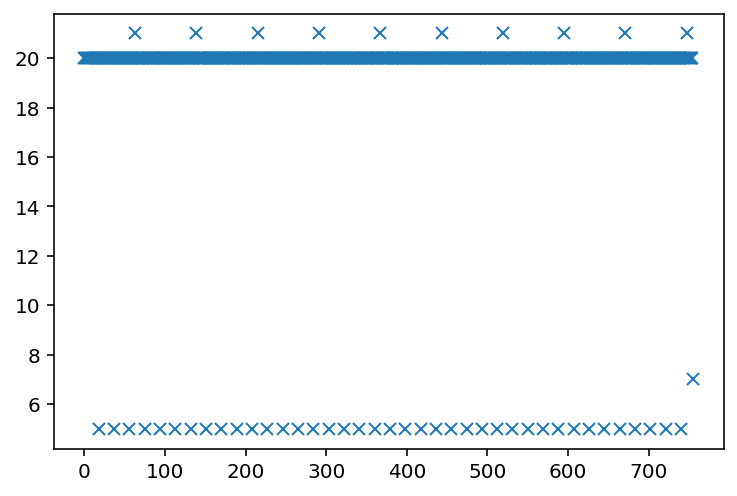

In [9]:
plt.plot(rechunked.chunksizes["time"], marker="x", ls="none")

And now our cohorts contain more than one group


In [10]:
flox.core.find_group_cohorts(
    labels=rechunked.time.dt.dayofyear.data,
    chunks=(rechunked.chunksizes["time"],),
)

dict_values([[344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363], [324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343], [304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323], [284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303], [264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283], [244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263], [159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178], [139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158], [119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138], [99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,

Now the groupby reduction **looks OK** in terms of number of tasks but remember
that rechunking to get to this point involves some communication overhead.


In [11]:
flox.xarray.xarray_reduce(
    rechunked, rechunked.time.dt.dayofyear, func="mean", method="cohorts"
)

<xarray.DataArray 'sst' (dayofyear: 366, lat: 720, lon: 1440)>
dask.array<transpose, shape=(366, 720, 1440), dtype=float64, chunksize=(20, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Dimensions without coordinates: lat, lon

## How about other climatologies?

Let's try monthly


In [12]:
flox.xarray.xarray_reduce(oisst, oisst.time.dt.month, func="mean")

<xarray.DataArray 'sst' (month: 12, lat: 720, lon: 1440)>
dask.array<transpose, shape=(12, 720, 1440), dtype=float64, chunksize=(12, 720, 1440), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: lat, lon

This looks great. Why?

It's because each chunk (size 20) is smaller than number of days in a typical
month. `flox` initially applies the groupby-reduction blockwise. For the chunk
size of 20, we will have at most 2 groups in each chunk, so the initial
blockwise reduction is quite effective - at least a 10x reduction in size from
20 elements in time to at most 2 elements in time.

For this kind of problem, `"map-reduce"` works quite well.
